In [197]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/PlatformIO/Projects/Cartpole/Julia/Project.toml`


In [198]:
using TrajectoryOptimization
using RobotDynamics
const RD = RobotDynamics
import RobotZoo.Cartpole
using StaticArrays
using SparseArrays
using LinearAlgebra
using ForwardDiff
using Plots
# using PyPlot
# pygui(true)
using JLD2
using LibSerialPort
using TickTock
using OSQP

In [199]:
ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.6389; # Old: 0.602
ENCODER_LINEAR_ANGULAR_RATIO_M = ENCODER_LINEAR_ANGULAR_RATIO_CM / 100; # Old: 0.00602
ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;
MOTOR_LINEAR_RPM_TO_CMPS = 50; 
CM_TO_M = 0.01
M_TO_CM = 100

decode_list = [
"linear_position", 
"linear_velocity", 
"shoulder_position", 
"shoulder_velocity", 
"elbow_position", 
"elbow_velocity",
"requested_vel_1",
"requested_vel_2",
"serial_tx_time",
# "time_since_last_command",
]

# takes inputs in m/s for cart
function write_motors(sp, linear_vel, elbow_vel)
    # max prescision of 3 decimal places
    linear_vel = round(linear_vel * MOTOR_LINEAR_RPM_TO_CMPS * M_TO_CM, digits=3) 
    elbow_vel = round(elbow_vel, digits=3)
    string_to_write = "<" * string(linear_vel) * ", " * string(elbow_vel) * ">"
    write(sp, string_to_write)
end


# Forward declare for runtime optimization
length_decode = length(decode_list)
length_decode_min_1 = length_decode - 1
length_decode_plus_1 = length_decode + 1

# returns in m/s
function safe_read(sp)
    timeout = 10
    while(timeout > 0)
        encoderData = readline(sp)
        try # catch byte errors in encoderData.decode
            encoderData = split(encoderData, ",")
            encoderData = encoderData[1:length_decode]
            encoderData = [parse(Float64, x) for x in encoderData]
            if length(encoderData) == length_decode # account for the \r\n 
                encoderData[1] *= -ENCODER_LINEAR_ANGULAR_RATIO_CM
                encoderData[2] *= -ENCODER_LINEAR_ANGULAR_RATIO_CM

                encoderData[1] *= CM_TO_M
                encoderData[2] *= CM_TO_M
                encoderData[7] *= CM_TO_M

                sp_flush(sp, SP_BUF_BOTH)
                return encoderData
            end
            timeout -= 1
            # println("Timeout during Read 1")
        catch
            timeout -= 1
            # println("Timeout during Read 0")
        end
    end
    println("Timeout during Read")
end

function busy_sleep(time_s)
    start = time()
    while (time() - start) < time_s
    end
end

busy_sleep (generic function with 1 method)

In [200]:
# model = Cartpole(mc = 0.4, mp = 0.215, l = 0.35)
model = Cartpole(mc = 0.4, mp = 0.2, l = 0.35)
n,m = size(model)
print("n: ", n, " m: ", m)

n: 4 m: 1

In [201]:
# N = 101
Tf = 10.
h = 0.025
N = Int(Tf/h) + 1
# h = Tf/(N-1)

x0 = @SVector ones(n)
x0 = x0 * 0.0001
xf = @SVector [0, pi, 0, 0];  # i.e. swing up

# Set up
Q = 1.0*Diagonal(@SVector [0, 1, 1, 1])
Qf = 100.0*Diagonal(@SVector [0, 1, 1, 1])
R = 0*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);


# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Control Bounds
u_pos = 15
u_neg = -u_pos
x_bound = [0.40, 100, 0.15, 100]
bnd = BoundConstraint(n,m, u_min=u_neg, u_max=u_pos, x_min = -x_bound, x_max = x_bound)
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, (N-5):N)

prob = Problem(model, obj, x0, Tf, xf=xf, constraints=conSet);

# give it a tiny initial perbutation
u0 = @SVector fill(0.0,m)
U0 = [u0 for k = 1:N-1]
duration = 0.2
steps = Int(duration/h)
for k = 1:steps
    U0[k] = [-5.]
end
for k = steps+1:2*steps
    U0[k] = [5.]
end
initial_controls!(prob, U0)
rollout!(prob);

┌ Warning: R needs to be positive definite.
└ @ TrajectoryOptimization /Users/saraltayal/.julia/packages/TrajectoryOptimization/cGEqd/src/cost_functions.jl:341


In [202]:
using Altro
opts = SolverOptions(
    cost_tolerance_intermediate=1e-3,
    penalty_scaling=10.,
    penalty_initial=1.0
)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 672
    Solve Time: 740.001208 (ms)

  Covergence
    Terminal Cost: 4782.9079798326875
    Terminal dJ: -0.08027507827591762
    Terminal gradient: 0.01801135285678855
    Terminal constraint violation: 6.44373450153779e-8
    Solve Status: SOLVE_SUCCEEDED


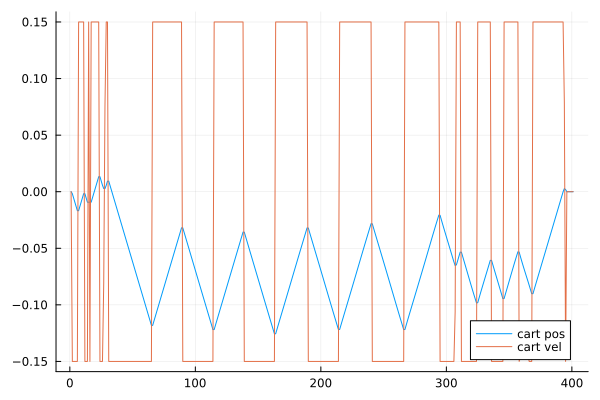

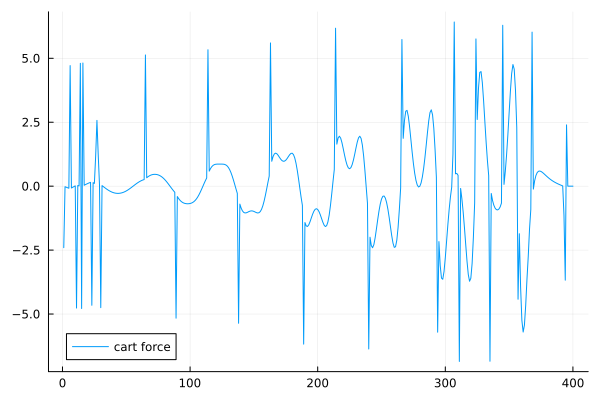

In [271]:
# Extract the solution
Xopt = states(altro);
Uopt = controls(altro);

xnom = zeros(n,N)
for k = 1:N
    xnom[:,k] .= Xopt[k]
end

unom = zeros(m,N-1)
utraj = zeros(m,N-1)
for k = 1:N-1
    unom[:,k] .= Uopt[k]
    utraj[:,k] .= Uopt[k]
end

plt = plot(xnom[1,:], label = "cart pos")
# plot!(xnom[2,:], label = "pendulum angle")
plot!(xnom[3,:], label = "cart vel")
# plot!(xnom[4,:], label = "pendulum vel")
display(plt)
gui()

plt = plot(utraj[1,:], label = "cart force")

In [204]:
# jldsave("cartpole_swingup_altro3.jld2"; Xopt, Uopt)

In [205]:
function dynamics_rk4(x, u)
    #RK4 integration with zero-order hold on u
    f1 = RD.dynamics(model, x, u)
    f2 = RD.dynamics(model, x + 0.5*h*f1, u)
    f3 = RD.dynamics(model, x + 0.5*h*f2, u)
    f4 = RD.dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

# #True model with friction
# function true_dynamics(model::Cartpole, x, u)
#     #Perturb masses of cart + pole
#     mc = model.mc + 0.02
#     mp = model.mp - 0.01
    
#     #Perturb length of pendulum
#     l = model.l + 0.005
#     g = model.g

#     q = x[ @SVector [1,2] ]
#     qd = x[ @SVector [3,4] ]

#     s = sin(q[2])
#     c = cos(q[2])

#     H = @SMatrix [mc+mp mp*l*c; mp*l*c mp*l^2]
#     C = @SMatrix [0 -mp*qd[2]*l*s; 0 0]
#     G = @SVector [0, mp*g*l*s]
#     B = @SVector [1, 0]
    
#     F = [0.01; 0.01].*tanh.(5.0*qd) #nonlinear friction (≈Coulomb/stiction)

#     qdd = -H\(C*qd + F + G - B*u[1])
#     return [qd; qdd]
# end

# function true_dynamics_rk4(x,u)
#     #RK4 integration with zero-order hold on u
#     f1 = true_dynamics(model, x, u)
#     f2 = true_dynamics(model, x + 0.5*h*f1, u)
#     f3 = true_dynamics(model, x + 0.5*h*f2, u)
#     f4 = true_dynamics(model, x + h*f3, u)
#     return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
# end

dynamics_rk4 (generic function with 1 method)

In [206]:
#Compute A and B matrices using nominal dynamics + trajectory
A = zeros(n,n,N-1)
B = zeros(n,m,N-1)
for k = 1:(N-1)
    A[:,:,k] .= ForwardDiff.jacobian(x->dynamics_rk4(x,Uopt[k]),Xopt[k])
    B[:,:,k] .= ForwardDiff.jacobian(u->dynamics_rk4(Xopt[k],u),Uopt[k])
end

In [207]:
#Compute LQR Tracking Controller
P = zeros(n,n,N)
K = zeros(m,n,N-1)
P[:,:,N] = Qf
for k = (N-1):-1:1
    K[:,:,k] .= (R + B[:,:,k]'*P[:,:,k+1]*B[:,:,k])\(B[:,:,k]'*P[:,:,k+1]*A[:,:,k])
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A[:,:,k]-B[:,:,k]*K[:,:,k])'*P[:,:,k+1]*(A[:,:,k]-B[:,:,k]*K[:,:,k])
end

In [209]:
# #Rollout with true dynamics
# xtraj = zeros(n,N)
# for k = 1:(N-1)
#     utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k]-xnom[:,k]) #with LQR tracking controller
#     utraj[:,k] .= min.(u_bnd, max.(-u_bnd, utraj[:,k])) #clip values within torque limits
#     xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
# end

In [307]:
# Rollout on robot

linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)
elbowRequested = zeros(N)
linearRequested = zeros(N)
loop_time_ms_array = zeros(N)
loop_time_ms_array_2 = zeros(N)
feedback_calculation = zeros(N)
feedback_velocity = zeros(N)
x_traj = zeros(n,N)
# velocity = [x[3] for x in xnom]
velocity = xtraj_ilc[3,:]

M_TO_CM = 100
sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 256000)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)
write_motors(sp, 0, 0)
encoder_data = safe_read(sp)

linearBaseLine = encoder_data[1] 
shoulderBaseLine = encoder_data[3]
println("linearBaseLine: ", linearBaseLine)
println("shoulderBaseLine: ", shoulderBaseLine)
fb_u = 0
test_k = 0.0001

x_sim_i = [encoder_data[1], shoulderPositions[3], linearVelocities[2], shoulderVelocities[4]]

# TODO: simulate closed loop system 
x_sim_i = [0, 0, 0, 0]
tick()
for i = 1:(N-1)
    start_iter = time()
    
    # println(i)
    speed = velocity[i] + fb_u

    u_base = unom[:,i][1]
    new_state = dynamics_rk4(x_sim_i, u_base) # + (0.001 * fb_u))
    new_vel = new_state[3]
    feedback_velocity[i] = new_vel

    clamp(new_vel, -0.5, 0.5)
    write_motors(sp, speed, speed)
    encoder_data = safe_read(sp)
    
    linearPositions[i] = encoder_data[1] - linearBaseLine
    linearVelocities[i] = encoder_data[2]
    shoulderPositions[i] = encoder_data[3] - shoulderBaseLine
    shoulderVelocities[i] = encoder_data[4]
    elbowPositions[i] = encoder_data[5]
    elbowVelocities[i] = encoder_data[6]
    linearRequested[i] = encoder_data[7]
    elbowRequested[i] = encoder_data[8]

    x_sim_i = [linearPositions[i], shoulderPositions[i], linearVelocities[i], shoulderVelocities[i]]
    x_traj[:,i+1] .= x_sim_i
    fb_u = -K[:,:,i]*(x_sim_i-xnom[:,i]) #with LQR tracking controller
    fb_u = test_k * fb_u[1]
    feedback_calculation[i] = fb_u


    loop_time_ms = (time() - start_iter)
    loop_time_ms_array[i] = loop_time_ms
    time_to_sleep = max(dt - loop_time_ms, 0)
    busy_sleep(time_to_sleep) # micro seconds
    loop_time_ms_2 = (time() - start_iter)
    loop_time_ms_array_2[i] = loop_time_ms_2
end
tock()

write_motors(sp, 0, 0)
close(sp)

linearBaseLine: 0.010535461000000001
shoulderBaseLine: 1.548


┌ Info:  started timer at: 2023-07-18T20:26:15.908
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54
┌ Info:         10.066862333s: 10 seconds, 66 milliseconds
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:62


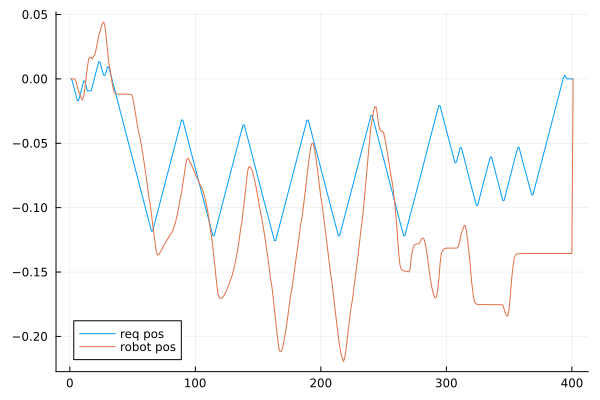

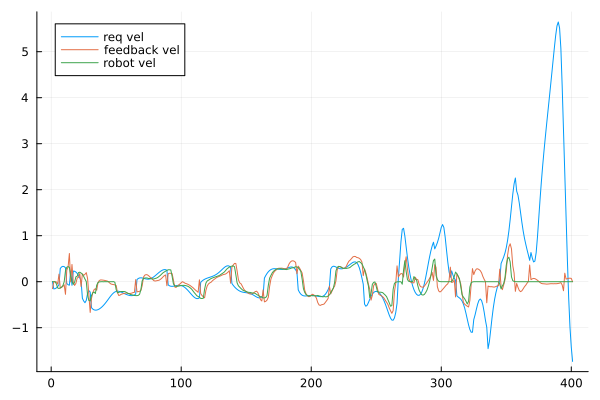

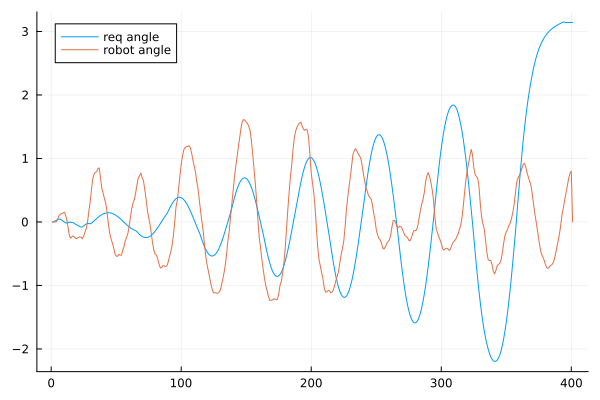

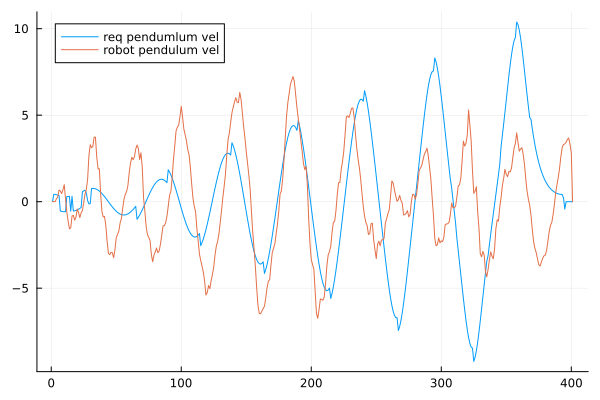

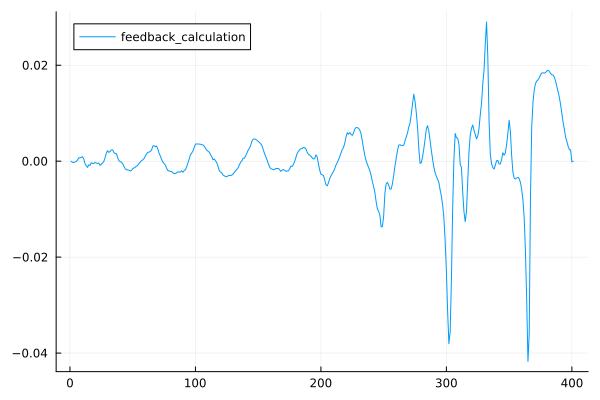

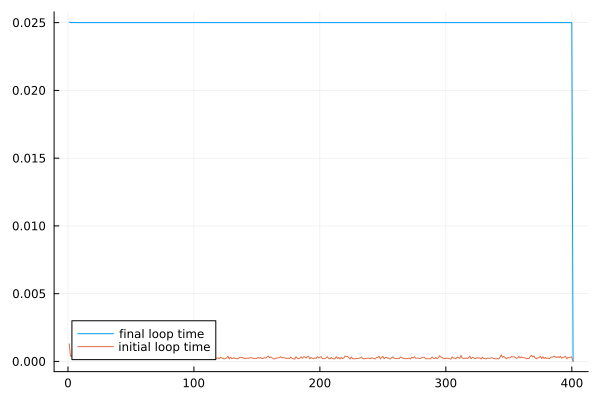

In [308]:
plt = plot(xnom[1,:], label = "req pos")
plot!(linearPositions, label = "robot pos")
display(plt)
gui()

plt2 = plot(velocity, label = "req vel")
plot!(feedback_velocity, label = "feedback vel")
plot!(linearVelocities, label = "robot vel")
display(plt2)

plt3 = plot(xnom[2, :], label = "req angle")
plot!(shoulderPositions, label = "robot angle")
display(plt3)

plt4 = plot(xnom[4, :], label = "req pendumlum vel")
plot!(shoulderVelocities, label = "robot pendulum vel")
display(plt4)

plt5 = plot(feedback_calculation, label = "feedback_calculation")
display(plt5)

plt6 = plot(loop_time_ms_array_2, label = "final loop time")
plot!(loop_time_ms_array, label = "initial loop time")
display(plt6)

In [224]:
# # test rk4 rollout
# xtraj_rk4 = zeros(n,N)

# for k = 1:(N-1)
#     x_curr = xtraj_rk4[:,k]
#     u_curr = unom[:,k] * 1.5
#     xtraj_rk4[:,k+1] .= dynamics_rk4(x_curr, u_curr)
end

In [299]:
#Build matrices for ILC QP
Nh = N
#Cost
Qilc = sparse(Diagonal([0.01; 0; 1.0; 0]))
Rilc = sparse(Diagonal([.1]))
H = blockdiag(kron(I(Nh-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf))
q = zeros((n+m)*(Nh-1))
for k = 1:(Nh-2)
    q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(xtraj[:,k+1]-Xopt[k+1])]
end
q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(xtraj[:,Nh]-Xopt[Nh])]

#Constraints
U = kron(I(Nh-1), [I zeros(m,n)]) #Matrix that picks out all u
X = kron(I(Nh-1), [zeros(n,m) I]) #Matrix that picks out all x
D = spzeros(n*(Nh-1), (n+m)*(Nh-1)) #dynamics constraints

D[1:n,1:m] .= B[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k = 1:(Nh-2)
    D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [A[:,:,k+1] B[:,:,k+1] -I]
end

lb = [zeros(n*(Nh-1)); -u_pos.-utraj[1:(Nh-1)]]
ub = [zeros(n*(Nh-1)); u_pos.-utraj[1:(Nh-1)]]

qp = OSQP.Model()
OSQP.setup!(qp, P=H, q=q, A=[D; U], l=lb, u=ub, eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf = 1.0e-6, eps_dual_inf = 1.0e-6, polish=1)
results = OSQP.solve!(qp)
ztraj = results.x;

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2000, constraints m = 2000
          nnz(P) + nnz(A) = 9989
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-06, eps_dual_inf = 1.0e-06,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.5543e+01   3.97e-01   1.88e+02   1.00e-01   2.20e-03s
 150  -4.9500e+01   1.75e-06   9.47e-05   2.91e-03   1.04e-02s
plsh  -4.9501e+01   7.78e-14   8.04e-09   -

In [300]:
Δu = U*ztraj
utraj[1:(Nh-1)] .= utraj[1:(Nh-1)]+Δu

400-element view(::Vector{Float64}, 1:400) with eltype Float64:
  -2.513859658672574
   0.06045723287622917
   0.22622529344615122
   0.39634274395532776
   0.5786811942353959
   5.593770900361018
   0.4938864053725525
   0.2272431568529371
  -0.027059972369304235
  -0.2767612066885466
   ⋮
 -13.039487369662643
 -15.0
 -15.0
 -15.0
 -15.0
 -15.0
 -15.0
 -15.0
 -15.0

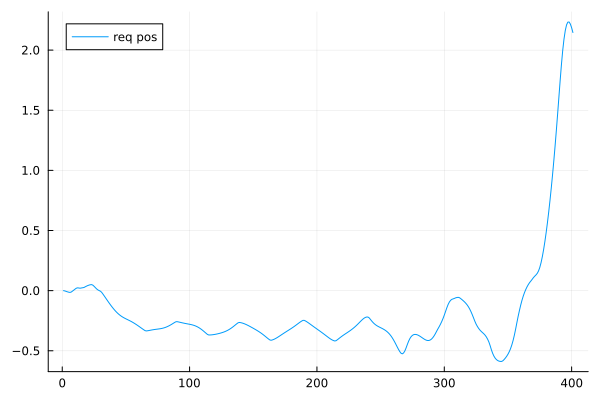

In [303]:
# simulate forward rollout
xtraj_ilc = zeros(n,N)
for k = 1:(N-1)
    xtraj_ilc[:,k+1] .= dynamics_rk4(xtraj_ilc[:,k], utraj[:,k])
end

plt = plot(xtraj_ilc[1,:], label = "req pos")
# plot!(xtraj_ilc[2,:], label = "req angle")
# plot!(xtraj_ilc[3,:], label = "req vel")

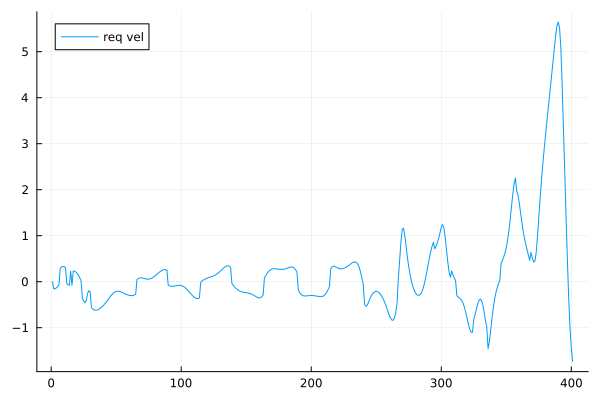

In [302]:
plot(xtraj_ilc[3,:], label = "req vel")